In [2]:
%matplotlib inline
import os
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
from mintpy.utils import ptime, utils as ut
from ipynb.fs.full import utils

work_dir = os.path.expanduser('~/Papers/2021_Geolocation/figs_src/TS')
os.chdir(work_dir)
print('Go to directory:', work_dir)

Go to directory: /Users/yunjunz/Papers/2021_Geolocation/figs_src/TS


In [12]:
ts_files = [os.path.expanduser('~/data/geolocation/ChileSenAT149/mintpy_offset/timeseriesRg_TECsub_SET_ERA5.h5'),
            os.path.expanduser('~/data/geolocation/ChileSenDT156/mintpy_offset/timeseriesRg_SET_ERA5.h5')]

lat, lon = [-21.30, -67.39]
for ts_file in ts_files:
    proj_name = os.path.basename(os.path.dirname(os.path.dirname(ts_file)))
    print('dataset: {}'.format(proj_name))
    geom_file = os.path.join(os.path.dirname(ts_file), 'inputs/geometryRadar.h5')
    dates, ts_dis = ut.read_timeseries_lalo(lat, lon, ts_file, lookup_file=geom_file, win_size=21, method='median', print_msg=False)[:2]

    # remove dates without sub-orbital TEC for ChileSenAT149
    if 'ChileSenAT149' in ts_file:
        date_listB = np.loadtxt(os.path.join(os.path.dirname(ts_file), 'S1B_date.txt'), dtype=str).tolist()
        datesB = ptime.date_list2vector(date_listB)[0]
        flagB = np.array([x in datesB for x in dates], dtype=np.bool_)
        bias_AB = np.array([0.087])
        ts_dis[flagB] -= bias_AB
        print('  correcting for Sentinel-1A/B bias: {:.1f} cm'.format(bias_AB[0]*100))

        if 'TECsub' in ts_file:
            tec_file = os.path.join(os.path.dirname(ts_file), 'inputs/TECsub.h5')
            tec_ts = ut.read_timeseries_lalo(lat, lon, tec_file, lookup_file=geom_file, print_msg=False)[1]
            flag = ~np.isnan(tec_ts)
            dates = dates[flag]
            ts_dis = ts_dis[flag]
            print('  ignore dates w/o sub-ortibal TEC')

    # remove S1A/B bias for ChileSenDT156
    if 'ChileSenDT156' in ts_file:
        bias_AB, flagA, flagB = utils.estimate_S1AB_bias(os.path.dirname(ts_file), dates, ts_dis)[:3]
        bias_AB = np.array([0.106])
        ts_dis[flagB] -= bias_AB
        print('  correcting for Sentinel-1A/B bias: {:.1f} cm'.format(bias_AB[0]*100))

        flagO = np.array([x != dt.datetime(2015,4,2) for x in dates], dtype=np.bool_)
        ts_dis = ts_dis[flagO]
        dates = dates[flagO]
        print('  remove outlier date 2015-04-02')

    # RMSE
    rmse = ut.root_mean_sq_error(ts_dis - np.median(ts_dis))
    print('  RMSE {:.1f} cm'.format(rmse*100))

dataset: ChileSenAT149
  correcting for Sentinel-1A/B bias: 8.7 cm
  ignore dates w/o sub-ortibal TEC
  RMSE 5.4 cm
dataset: ChileSenDT156
  correcting for Sentinel-1A/B bias: 10.6 cm
  remove outlier date 2015-04-02
  RMSE 5.3 cm


save figure to file /Users/yunjunz/Papers/2021_Geolocation/figs_src/TS/ts_res_ChileSenDT156.png


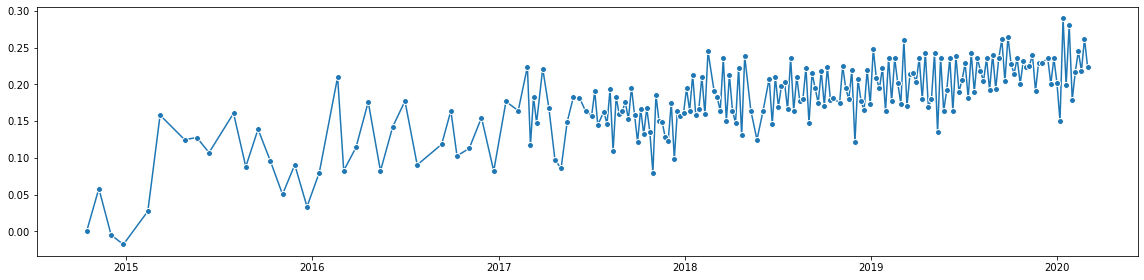

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[16, 4])
ax.plot(dates, ts_dis, 'o-', mec='white')
#ax.set_xlim(xmin=dt.datetime(2017,6,1), xmax=dt.datetime(2020,4,1))
#ax.set_ylim(-0.1, 0.4)
fig.tight_layout()

# output
out_fig = os.path.abspath('ts_res_{}.png'.format(proj_name))
print('save figure to file', out_fig)
#plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

In [23]:
ut.root_mean_sq_error(ts_dis - np.median(ts_dis))

0.05309694831078231